# Recommendations with IBM

In this notebook, different methods for making recommendation have been explored using real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Conclusion](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

# loading data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Let's explore the distribution of user interactions with the articles.

Text(0.5,1,'Histogram (users interaction)')

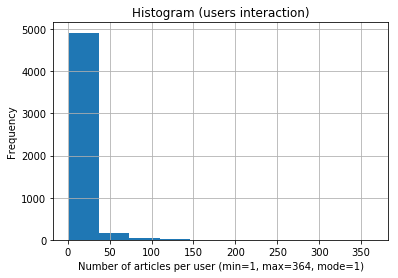

In [3]:
# distribution of users interaction with articles 
articles_per_user = df.groupby(["email"]).count()["article_id"]
articles_per_user.hist()
plt.xlabel("Number of articles per user (min={}, max={}, mode={})".format(
    articles_per_user.min(), articles_per_user.max(), articles_per_user.mode()[0]))
plt.ylabel("Frequency")
plt.title("Histogram (users interaction)")

Text(0.5,1,'Histogram (articles popularity)')

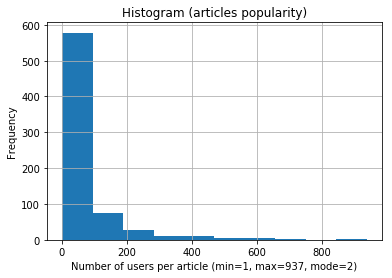

In [4]:
# distribution of articles popularity
users_per_article = df.groupby(["article_id"]).count()["email"]
users_per_article.hist()
plt.xlabel("Number of users per article (min={}, max={}, mode={})".format(
    users_per_article.min(), users_per_article.max(), users_per_article.mode()[0]))
plt.ylabel("Frequency")
plt.title("Histogram (articles popularity)")

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Check for duplicates in the df_content dataset
articles_value_counts = df_content["article_id"].value_counts()
df_content[df_content["article_id"].isin(articles_value_counts[articles_value_counts > 1].index)].sort_values(by=["article_id"])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [6]:
# Remove duplicate rows that have the same article_id
df_content.drop_duplicates(subset=["article_id"], keep="first", inplace=True)

`3.` Let's find answers to below questions:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset. <br>
**e.** The most viewed article and number of times it is viewed.

In [7]:
# Number of unique articles that have at least one interaction
unique_articles = df["article_id"].nunique()
# Number of unique articles in the data
total_articles = df_content["article_id"].nunique()
# Number of unique users
unique_users = df["email"].nunique()
# Number of user-article interactions
user_article_interactions = df.shape[0]

unique_articles, total_articles, unique_users, user_article_interactions

(714, 1051, 5148, 45993)

In [8]:
# The most viewed article in the dataset
most_viewed_article_id = str(df["article_id"].mode()[0])
# Number of times it is viewed
max_views = (df["article_id"] == df["article_id"].mode()[0]).sum()

most_viewed_article_id, max_views

('1429.0', 937)

`4.` Map the user email to a user_id column and remove the email column.

In [9]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In this case, the popularity of an article can be based on how often an article was interacted with.

`1.` Let's create a function below to return the **n** top articles ordered with most interactions as the top.

In [10]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    articles_ranked = df.groupby(["article_id"]).count()["user_id"].sort_values(ascending=False)
    top_articles_ids = articles_ranked.iloc[:n].index.tolist()
    return top_articles_ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_ids = get_top_article_ids(n, df=df)
    top_articles = df[df["article_id"].isin(top_articles_ids)]["title"].unique().tolist()
    return top_articles

In [11]:
# Top 5 articles
top_5 = get_top_articles(5)
top_5

['use deep learning for image classification',
 'predicting churn with the spss random tree algorithm',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'insights from new york car accident reports']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Let's reformat the **df** dataframe and create a user-item matrix to be shaped with users as the rows and articles as the columns. It'll follow below mentioned ideas.


* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [12]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(["user_id", "article_id"]).agg(lambda x: 1).unstack(fill_value=0)
    return user_item

user_item = create_user_item_matrix(df)

`2.` Let's complete the function below which will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [13]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim_arr = np.dot(user_item, user_item.loc[user_id, :])
    sim_data = pd.Series(sim_arr, index=user_item.index)

    # sort by similarity
    sim_data.sort_values(ascending=False, inplace=True)

    # create list of just the ids
    most_similar_users = sim_data.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users

`3.` Now that we have a function that provides the most similar users to each user, we will use these users to find articles we can recommend.

In [14]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    
    Description:
    Return the article names associated with list of article ids
    '''
    article_names = [df[df["article_id"] == float(art_id)]["title"].values[0] for art_id in article_ids]
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_articles = user_item.loc[user_id, :]
    article_ids = [str(art_id) for art_id in user_articles[user_articles == 1].index.get_level_values("article_id").tolist()]
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    sim_users = find_similar_users(user_id, user_item)
    curr_user_articles_ids, _ = get_user_articles(user_id, user_item)
    counter = 0
    recs = []
    for user in sim_users:
        if(counter > m):
                break
        sim_usr_article_ids, _ = get_user_articles(user, user_item)
        for article_id in sim_usr_article_ids:
            if(counter > m):
                break
            if(article_id not in curr_user_articles_ids):
                recs.append(article_id)
                counter += 1
    return recs 

In [15]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame',
 'this week in data science (may 2, 2017)']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [16]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity = np.dot(user_item, user_item.loc[user_id, :])
    neighbor_id = user_item.index.tolist()
    num_interactions = df.groupby(["user_id"]).count()["article_id"].values
    neighbors_df = pd.DataFrame.from_dict({
        "neighbor_id": neighbor_id,
        "similarity": similarity,
        "num_interactions": num_interactions
    })
    neighbors_df.sort_values(by=["similarity", "num_interactions"], ascending=False, inplace=True)
    # drop entry for self
    neighbors_df = neighbors_df[neighbors_df["neighbor_id"] != user_id]
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors = get_top_sorted_users(user_id)["neighbor_id"]
    counter = 0
    curr_user_articles, _ = get_user_articles(user_id)
    recs = []
    article_interaction_count = df.groupby(["article_id"]).count()["user_id"]
    for user in neighbors:
        if(counter > m):
            break
        user_articles, _ = get_user_articles(user)
        ranked_user_articles = article_interaction_count[[float(art_id) for art_id in user_articles]].sort_values(ascending=True).index.tolist()
        for article in ranked_user_articles:
            if(counter > m):
                break
            if(article not in curr_user_articles):
                recs.append(article)
                counter += 1
    rec_names = get_article_names(recs)
    return recs, rec_names

In [17]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1335.0, 1346.0, 555.0, 1444.0, 1085.0, 1151.0, 1153.0, 1154.0, 1152.0, 686.0, 1407.0]

The top 10 recommendations for user 20 are the following article names:
['labor', 'military expenditure as % of gdp by country', 'build a naive-bayes model with wml & dsx', 'worldwide fuel oil consumption by household (in 1000 metric tons)', 'airbnb data for analytics: chicago listings', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: venice reviews', 'score a predictive model built with ibm spss modeler, wml & dsx', 'uci: poker hand - testing data set']


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (TO DO)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.

We will consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

One additional idea is that we might want to choose the most popular recommendations that meet our 'content criteria', but again, there is a lot of flexibility in how we might make these recommendations.

`1.` Let's use the function body below to create a content based recommender.

In [18]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Let's use the content-recommendation system to make recommendations for the below scenarios based on the comments.  

In [19]:
# Make recommendations for a brand new user



# Make a recommendations for a user who only has interacted with article id '1427.0' for eg



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [20]:
# quick look at the user-item matrix
user_item_matrix = user_item
user_item_matrix.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1               0      0      0      0      0      0      0      0      0   
2               0      0      0      0      0      0      0      0      0   
3               0      0      0      0      0      1      0      0      0   
4               0      0      0      0      0      0      0      0      0   
5               0      0      0      0      0      0      0      0      0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1               0  ...        0      0      1      0      1      0      0   
2               0  ...        0      0      0      0      0      0      0   
3               0  ...        0      0      1      0      0      0      0   
4               0  ...        0      0      0      0      0      0      0   
5               0  ...        0      0      0      0      0      0      0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1               0      0      0  
2               0      0      0  
3               0      0      0  
4               0      0      0  
5               0      0      0  

[5 rows x 714 columns]

`1.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [21]:
# Perform SVD on the user-item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)

`2.` Now for the tricky part, how do we choose the number of latent features to use?  Let's run the below cell.

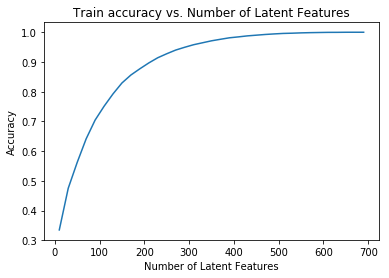

In [22]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Train accuracy vs. Number of Latent Features');

We can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

`3.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.

In [23]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(["user_id", "article_id"]).agg(lambda x: 1).unstack(fill_value=0)
    user_item_test = df_test.groupby(["user_id", "article_id"]).agg(lambda x: 1).unstack(fill_value=0)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

Using the split above let's answer below questions: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [24]:
# common users in train and test data
test_users = set(test_idx)
train_users = set(user_item_train.index.tolist())
common_users = list(test_users & train_users)
common_users.sort()
len(common_users)

20

In [25]:
# common articles in train and test data
test_articles = set(test_arts)
train_articles = set(user_item_train.columns.tolist())
common_articles = list(test_articles & train_articles)
common_articles.sort()
len(common_articles)

574

In [26]:
# users in test and not in train - unable to make predictions
len(test_users - train_users)

662

In [27]:
# articles in test but not in train
len(test_articles - train_articles)

0

`4.` Now using the **user_item_train** dataset from above we'll find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.

In [28]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

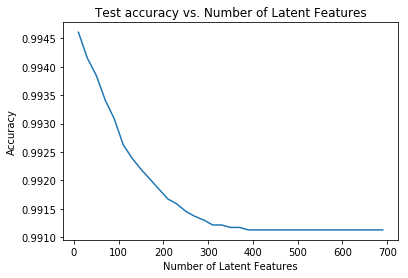

In [29]:
# indices of users/articles common to both train and test data
common_users_idx = [user_item_train.index.get_loc(user) for user in common_users]
common_articles_idx = [user_item_train.columns.get_loc(article) for article in common_articles]

# common test data
test_common = user_item_test.loc[common_users, common_articles].values

# reduced factorized matrices
u_train_common, vt_train_common = u_train[common_users_idx, :], vt_train[:, common_articles_idx]

# predict and plot
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []
for k in num_latent_feats:
    # restructure with k latent features
    u_new, s_new, vt_new = u_train_common[:, : k], np.diag(s_train[: k]), vt_train_common[: k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(test_common, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Test accuracy vs. Number of Latent Features');

`5.` **Observations/Comments**
* From the above plot, it can be observed that increasing the number of latent features is deteriorating the predictions. Accuray is decreasing with the increase in the number of latent features being used to generate predictions. Overfitting could be the cause for the same.
* For users not present in train data, content based recommendation methods can be used to suggest articles.
* We can test the increase in engagement of users, if any, using this recommendation engine by adopting A/B testing. We separate users in two groups, one gets our recommedations and the other group is provided random recommendations. Comparing the hit rates (evaluation metric) of the recommended articles can then be used to measure any boost in the view count. If it is significant, we can conclude that our recommendation engine works well.